# 第8章：速度提升I：设备(Device)

本笔记本演示了第8章中关于计算设备优化的关键概念和技术，包括:
1. 不同计算设备的性能比较
2. CUDA编程基础
3. PyTorch中的设备操作
4. 内存管理与数据传输优化
5. 混合精度训练
6. 多设备协作

In [ ]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# # 检查可用设备
try:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    # 测试MPS是否真的可用
    if str(device) == "mps":
        a = torch.randn((1,), device=device)
except RuntimeError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: mps


## 1. 比较CPU和GPU性能

首先，我们比较CPU和GPU在基本矩阵运算上的性能差异。

矩阵大小: 500x500, CPU: 0.000983秒, GPU/MPS: 0.000605秒
矩阵大小: 1000x1000, CPU: 0.001944秒, GPU/MPS: 0.001808秒
矩阵大小: 2000x2000, CPU: 0.015240秒, GPU/MPS: 0.006020秒
矩阵大小: 3000x3000, CPU: 0.040458秒, GPU/MPS: 0.013284秒
矩阵大小: 4000x4000, CPU: 0.088027秒, GPU/MPS: 0.034690秒


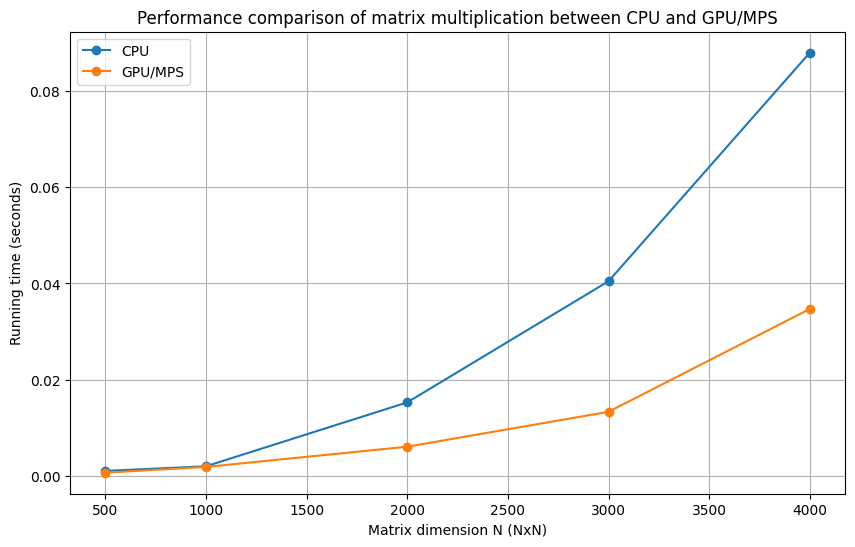

In [ ]:

def compare_matrix_multiplication(sizes):
    """比较不同大小矩阵在CPU、GPU（CUDA/MPS）上乘法运算的性能"""
    cpu_times = []
    gpu_times = []
    
    # 检查是否有可用的加速设备（CUDA 或 MPS）
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    for size in sizes:
        # 创建随机矩阵
        a_cpu = torch.randn(size, size)
        b_cpu = torch.randn(size, size)
        
        # CPU 计时
        start_time = time.time()
        c_cpu = torch.matmul(a_cpu, b_cpu)
        cpu_time = time.time() - start_time
        cpu_times.append(cpu_time)
        
        # 如果有 CUDA 或 MPS，测试 GPU/MPS 性能
        if use_cuda or use_mps:
            device = "cuda" if use_cuda else "mps"
            a_gpu = a_cpu.to(device)
            b_gpu = b_cpu.to(device)
            
            # 预热（避免第一次运行时的初始化开销）
            _ = torch.matmul(a_gpu, b_gpu)
            if use_cuda:
                torch.cuda.synchronize()  # CUDA 需要同步
            elif use_mps:
                torch.mps.synchronize()   # MPS 也需要同步（PyTorch 2.0+）
            
            # GPU/MPS 计时
            start_time = time.time()
            c_gpu = torch.matmul(a_gpu, b_gpu)
            if use_cuda:
                torch.cuda.synchronize()
            elif use_mps:
                torch.mps.synchronize()
            gpu_time = time.time() - start_time
            gpu_times.append(gpu_time)
        else:
            gpu_times.append(None)
        
        # 正确处理 None 的情况
        gpu_time_str = f"{gpu_times[-1]:.6f}" if gpu_times[-1] is not None else "N/A"
        print(f"矩阵大小: {size}x{size}, CPU: {cpu_time:.6f}秒, GPU/MPS: {gpu_time_str}秒")
    
    return cpu_times, gpu_times

# 测试不同大小的矩阵
matrix_sizes = [500, 1000, 2000, 3000, 4000]
cpu_times, gpu_times = compare_matrix_multiplication(matrix_sizes)

# 绘制比较图（如果有 GPU/MPS 数据）
if any(t is not None for t in gpu_times):
    plt.figure(figsize=(10, 6))
    plt.plot(matrix_sizes, cpu_times, 'o-', label='CPU')
    plt.plot(matrix_sizes, gpu_times, 'o-', label='GPU/MPS')
    # plt.xlabel('矩阵维度 N (NxN)')
    # plt.ylabel('运行时间 (秒)')
    # plt.title('CPU 与 GPU/MPS 矩阵乘法性能比较')
    plt.xlabel('Matrix dimension N (NxN)')
    plt.ylabel('Running time (seconds)')
    plt.title('Performance comparison of matrix multiplication between CPU and GPU/MPS')
    plt.legend()
    plt.grid(True)
    plt.show()

## 2. PyTorch中的设备操作

下面演示如何在PyTorch中使用不同设备，并查看设备信息。

In [6]:
import torch

# 检查 CUDA 是否可用
if torch.cuda.is_available():
    # 获取可用 GPU 数量
    device_count = torch.cuda.device_count()
    print(f"发现 {device_count} 个 CUDA 设备")
    
    # 打印 GPU 信息
    for i in range(device_count):
        device_properties = torch.cuda.get_device_properties(i)
        print(f"设备 {i}: {device_properties.name}")
        print(f"  计算能力: {device_properties.major}.{device_properties.minor}")
        print(f"  总内存: {device_properties.total_memory / 1e9:.2f} GB")
        print(f"  多处理器数量: {device_properties.multi_processor_count}")

# 检查 MPS 是否可用（Mac M1/M2 GPU）
elif torch.backends.mps.is_available():
    print("MPS 可用（Apple Metal GPU 加速）")
    print(f"设备: Apple M1/M2 GPU (Metal)")
    
    # 获取 MPS 设备信息（PyTorch 2.0+ 支持）
    if hasattr(torch.backends.mps, "is_available"):
        print(f"  MPS 后端版本: {torch.backends.mps.is_built()}")  # 是否已编译
        print(f"  MPS 是否可用: {torch.backends.mps.is_available()}")  # 是否可用
    else:
        print("  MPS 设备信息获取受限（需 PyTorch 2.0+）")

# 如果 CUDA 和 MPS 都不可用，则仅使用 CPU
else:
    print("CUDA 和 MPS 均不可用，仅使用 CPU。")

MPS 可用（Apple Metal GPU 加速）
设备: Apple M1/M2 GPU (Metal)
  MPS 后端版本: True
  MPS 是否可用: True


In [7]:
import torch
import time

# 创建CPU张量
x_cpu = torch.randn(1000, 1000)
print(f"x_cpu设备: {x_cpu.device}")

# 检查是否有可用的加速设备（CUDA 或 MPS）
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda or use_mps:
    device = "cuda" if use_cuda else "mps"
    
    # 测量移动时间（CPU -> GPU/MPS）
    start_time = time.time()
    x_gpu = x_cpu.to(device)
    if use_cuda:
        torch.cuda.synchronize()  # CUDA 需要同步
    elif use_mps:
        torch.mps.synchronize()   # MPS 也需要同步（PyTorch 2.0+）
    transfer_time = time.time() - start_time
    
    print(f"x_gpu设备: {x_gpu.device}")
    print(f"CPU到GPU/MPS传输时间: {transfer_time*1000:.2f} ms")
    
    # 移回CPU
    start_time = time.time()
    x_back_to_cpu = x_gpu.cpu()
    if use_cuda:
        torch.cuda.synchronize()
    elif use_mps:
        torch.mps.synchronize()
    transfer_back_time = time.time() - start_time
    
    print(f"GPU/MPS到CPU传输时间: {transfer_back_time*1000:.2f} ms")
    
    # 检查数据是否一致
    print(f"传输前后数据是否一致: {torch.allclose(x_cpu, x_back_to_cpu)}")
else:
    print("CUDA和MPS均不可用，仅使用CPU。")

x_cpu设备: cpu
x_gpu设备: mps:0
CPU到GPU/MPS传输时间: 1.12 ms
GPU/MPS到CPU传输时间: 0.98 ms
传输前后数据是否一致: True


## 3. 构建一个简单的神经网络并比较CPU/GPU性能

我们创建一个简单的Transformer编码器模型，并比较在CPU和GPU上的性能。

In [8]:
import torch
import torch.nn as nn
import time

class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size=10000, d_model=512, nhead=8, num_layers=6):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return self.fc_out(x)

def compare_model_performance(batch_size=16, seq_length=128):
    # 创建模型
    model = SimpleTransformerModel(vocab_size=10000, d_model=512, nhead=8, num_layers=2)
    
    # 生成随机输入数据
    input_data = torch.randint(0, 10000, (batch_size, seq_length))
    
    # CPU性能测试
    model.to("cpu")
    start_time = time.time()
    with torch.no_grad():
        output_cpu = model(input_data)
    cpu_time = time.time() - start_time
    print(f"CPU推理时间: {cpu_time:.4f}秒")
    
    # 检查可用设备
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    # GPU/MPS性能测试（如果可用）
    if use_cuda or use_mps:
        device = "cuda" if use_cuda else "mps"
        model.to(device)
        input_data_device = input_data.to(device)
        
        # 预热
        with torch.no_grad():
            _ = model(input_data_device)
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
        
        # 测量性能
        start_time = time.time()
        with torch.no_grad():
            output_device = model(input_data_device)
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
        device_time = time.time() - start_time
        
        device_name = "GPU" if use_cuda else "MPS"
        print(f"{device_name}推理时间: {device_time:.4f}秒")
        
        if device_time > 0:
            speedup = cpu_time / device_time
            print(f"{device_name}加速比: {speedup:.2f}x")
    
    return model

# 运行比较
model = compare_model_performance(batch_size=32, seq_length=256)

/Users/gatilin/miniconda3/envs/pro/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


CPU推理时间: 0.7796秒
MPS推理时间: 0.3446秒
MPS加速比: 2.26x


## 4. 内存管理与数据传输优化

这部分演示内存管理技术和如何优化数据传输。

In [9]:
def memory_management_demo():
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    if use_cuda or use_mps:
        device = "cuda" if use_cuda else "mps"
        device_name = "GPU" if use_cuda else "MPS"
        
        if use_cuda:
            # CUDA特有的内存管理功能
            torch.cuda.empty_cache()
            print(f"初始{device_name}内存分配: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"初始{device_name}内存保留: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
        
        # 分配大型张量
        print(f"\n分配大型张量到{device_name}...")
        x = torch.randn(5000, 5000, device=device)
        
        if use_cuda:
            print(f"分配后{device_name}内存: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        
        # 释放张量
        print(f"\n删除{device_name}张量...")
        del x
        
        if use_cuda:
            print(f"删除后{device_name}内存分配: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"删除后{device_name}内存保留: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
            print("\n清空缓存...")
            torch.cuda.empty_cache()
            print(f"清空后{device_name}内存保留: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
        
        # 演示内存传输速度
        print(f"\n测试{device_name}内存传输速度:")
        size = 10000000  # 10M元素
        
        # 非固定内存传输
        x_non_pinned = torch.randn(size)
        start_time = time.time()
        x_device = x_non_pinned.to(device)
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
        non_pinned_time = time.time() - start_time
        print(f"非固定内存传输时间: {non_pinned_time*1000:.2f} ms")
        
        # 固定内存传输（仅CUDA支持）
        if use_cuda:
            x_pinned = torch.randn(size).pin_memory()
            start_time = time.time()
            x_device = x_pinned.to("cuda", non_blocking=True)
            torch.cuda.synchronize()
            pinned_time = time.time() - start_time
            print(f"固定内存传输时间: {pinned_time*1000:.2f} ms")
            print(f"加速比: {non_pinned_time/pinned_time:.2f}x")
        else:
            print("注意: MPS设备不支持固定内存(pinned memory)功能")
    else:
        print("CUDA和MPS均不可用，无法演示GPU内存管理。")

# 运行内存管理演示
memory_management_demo()


分配大型张量到MPS...

删除MPS张量...

测试MPS内存传输速度:
非固定内存传输时间: 8.13 ms
注意: MPS设备不支持固定内存(pinned memory)功能


## 5. CUDA流与并行计算

下面演示如何使用CUDA流实现并行计算。

In [10]:
def device_streams_demo():
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    if use_cuda or use_mps:
        device = "cuda" if use_cuda else "mps"
        device_name = "CUDA" if use_cuda else "MPS"
        
        if use_cuda:
            # CUDA特有的流功能
            stream1 = torch.cuda.Stream()
            stream2 = torch.cuda.Stream()
            # 创建事件来测量时间
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
        else:
            # MPS使用默认流（目前PyTorch MPS后端没有显式的流控制）
            print("注意: MPS目前不支持显式的流控制，将演示默认行为")
        
        # 创建测试数据
        data1 = torch.randn(2000, 2000, device=device)
        data2 = torch.randn(2000, 2000, device=device)
        result1 = torch.zeros(2000, 2000, device=device)
        result2 = torch.zeros(2000, 2000, device=device)
        
        if use_cuda:
            # 记录开始时间
            start_event.record()
            
            # 在第一个流中执行操作
            with torch.cuda.stream(stream1):
                for _ in range(20):
                    result1 = torch.matmul(data1, data1)
            
            # 在第二个流中执行操作
            with torch.cuda.stream(stream2):
                for _ in range(20):
                    result2 = torch.matmul(data2, data2)
            
            # 同步所有流
            torch.cuda.synchronize()
            
            # 记录结束时间
            end_event.record()
            end_event.synchronize()
            
            # 计算并行执行时间
            parallel_time = start_event.elapsed_time(end_event)
        else:
            # MPS的"伪并行"执行（实际上会顺序执行）
            start_time = time.time()
            for _ in range(20):
                result1 = torch.matmul(data1, data1)
            for _ in range(20):
                result2 = torch.matmul(data2, data2)
            torch.mps.synchronize()
            parallel_time = (time.time() - start_time) * 1000  # 转换为毫秒
        
        print(f"{device_name}并行执行时间: {parallel_time:.2f} ms")
        
        # 比较串行执行
        if use_cuda:
            start_event.record()
        
        start_time = time.time() if not use_cuda else None
        for _ in range(20):
            result1 = torch.matmul(data1, data1)
            if use_mps:
                torch.mps.synchronize()  # MPS需要同步以确保准确计时
        
        for _ in range(20):
            result2 = torch.matmul(data2, data2)
            if use_mps:
                torch.mps.synchronize()
        
        if use_cuda:
            end_event.record()
            end_event.synchronize()
            serial_time = start_event.elapsed_time(end_event)
        else:
            torch.mps.synchronize()
            serial_time = (time.time() - start_time) * 1000
        
        print(f"{device_name}串行执行时间: {serial_time:.2f} ms")
        
        # 计算加速比
        if parallel_time > 0:
            speedup = serial_time / parallel_time
            print(f"使用{device_name}的加速比: {speedup:.2f}x")
    else:
        print("CUDA和MPS均不可用，无法演示并行计算。")

# 运行流演示
device_streams_demo()

注意: MPS目前不支持显式的流控制，将演示默认行为
MPS并行执行时间: 196.29 ms
MPS串行执行时间: 202.02 ms
使用MPS的加速比: 1.03x


## 6. 混合精度训练

演示使用PyTorch的自动混合精度功能进行模型训练。

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader  # 添加这行导入
def mixed_precision_demo():
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    if use_cuda or use_mps:
        device = "cuda" if use_cuda else "mps"
        device_name = "CUDA" if use_cuda else "MPS"
        
        # 创建一个小型数据集
        class RandomDataset(Dataset):
            def __init__(self, size=1000):
                self.input_data = torch.randint(0, 10000, (size, 128))
                self.target_data = torch.randint(0, 10000, (size, 128))
                
            def __len__(self):
                return len(self.input_data)
                
            def __getitem__(self, idx):
                return self.input_data[idx], self.target_data[idx]
        
        # 创建数据加载器
        dataset = RandomDataset(size=1000)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        # 创建模型
        model = SimpleTransformerModel(vocab_size=10000, d_model=512, nhead=8, num_layers=2)
        model = model.to(device)
        
        # 定义损失函数和优化器
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 标准FP32训练
        print(f"\n开始FP32训练({device_name})...")
        model.train()
        start_time = time.time()
        
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= 10:  # 只训练几批以进行演示
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 10000), targets.view(-1))
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
            
        fp32_time = time.time() - start_time
        print(f"FP32训练时间: {fp32_time:.4f}秒")
        
        # 检查是否支持自动混合精度
        print(f"\n使用自动混合精度训练({device_name})...")
        
        # 重置模型
        model = SimpleTransformerModel(vocab_size=10000, d_model=512, nhead=8, num_layers=2)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 混合精度训练
        if use_cuda:
            from torch.cuda.amp import autocast, GradScaler
            scaler = GradScaler()
        else:
            # MPS使用不同的混合精度实现
            model = model.to(torch.float16)
            print("注意: MPS使用torch.float16进行混合精度训练")
        
        model.train()
        start_time = time.time()
        
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= 10:  # 只训练几批以进行演示
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            if use_cuda:
                # CUDA自动混合精度
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs.view(-1, 10000), targets.view(-1))
                
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # MPS混合精度
                inputs = inputs.to(torch.float16)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 10000).float(), targets.view(-1))
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
            
        amp_time = time.time() - start_time
        print(f"混合精度训练时间: {amp_time:.4f}秒")
        
        # 比较性能
        if amp_time > 0:
            speedup = fp32_time / amp_time
            print(f"混合精度加速比: {speedup:.2f}x")
            
        # 比较内存使用
        if use_cuda:
            print("\n进行内存使用比较...")
            torch.cuda.empty_cache()
            model_fp32 = SimpleTransformerModel(vocab_size=10000, d_model=512, nhead=8, num_layers=2).to("cuda")
            inputs = torch.randint(0, 10000, (32, 128)).to("cuda")
            
            # FP32内存使用
            before_mem = torch.cuda.memory_allocated()
            outputs_fp32 = model_fp32(inputs)
            after_mem = torch.cuda.memory_allocated()
            fp32_mem = after_mem - before_mem
            print(f"FP32前向传播额外内存: {fp32_mem / 1e6:.2f} MB")
            
            # 混合精度内存使用
            torch.cuda.empty_cache()
            before_mem = torch.cuda.memory_allocated()
            with autocast():
                outputs_half = model_fp32(inputs)
            after_mem = torch.cuda.memory_allocated()
            half_mem = after_mem - before_mem
            print(f"混合精度前向传播额外内存: {half_mem / 1e6:.2f} MB")
            
            print(f"内存节省: {(1 - half_mem/fp32_mem)*100:.2f}%")
        else:
            print("\n注意: MPS目前不提供详细的内存统计功能")
    else:
        print("CUDA和MPS均不可用，无法演示混合精度训练。")

# 运行混合精度训练演示
mixed_precision_demo()


开始FP32训练(MPS)...
FP32训练时间: 4.6603秒

使用自动混合精度训练(MPS)...


/Users/gatilin/miniconda3/envs/pro/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


注意: MPS使用torch.float16进行混合精度训练


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got MPSHalfType instead (while checking arguments for embedding)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

def mixed_precision_demo():
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    
    if use_cuda or use_mps:
        device = "cuda" if use_cuda else "mps"
        device_name = "CUDA" if use_cuda else "MPS"
        
        # 创建一个小型数据集
        class RandomDataset(Dataset):
            def __init__(self, size=1000):
                self.input_data = torch.randint(0, 10000, (size, 128))
                self.target_data = torch.randint(0, 10000, (size, 128))
                
            def __len__(self):
                return len(self.input_data)
                
            def __getitem__(self, idx):
                return self.input_data[idx], self.target_data[idx]
        
        # 创建数据加载器
        dataset = RandomDataset(size=1000)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        # 创建模型
        model = SimpleTransformerModel(vocab_size=10000, d_model=512, nhead=8, num_layers=2)
        model = model.to(device)
        
        # 定义损失函数和优化器
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 标准FP32训练
        print(f"\n开始FP32训练({device_name})...")
        model.train()
        start_time = time.time()
        
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= 10:  # 只训练几批以进行演示
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 10000), targets.view(-1))
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
            
        fp32_time = time.time() - start_time
        print(f"FP32训练时间: {fp32_time:.4f}秒")
        
        # 检查是否支持自动混合精度
        print(f"\n使用自动混合精度训练({device_name})...")
        
        # 重置模型
        model = SimpleTransformerModel(vocab_size=10000, d_model=512, nhead=8, num_layers=2)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 混合精度训练
        if use_cuda:
            from torch.cuda.amp import autocast, GradScaler
            scaler = GradScaler()
        else:
            # MPS使用不同的混合精度实现
            # 注意：不要将输入转换为float16，因为Embedding层需要整数输入
            model = model.to(torch.float16)
            print("注意: MPS使用torch.float16进行混合精度训练")
        
        model.train()
        start_time = time.time()
        
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= 10:  # 只训练几批以进行演示
                break
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            if use_cuda:
                # CUDA自动混合精度
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs.view(-1, 10000), targets.view(-1))
                
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # MPS混合精度
                # 注意：不要转换inputs为float16，因为Embedding层需要整数输入
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 10000).float(), targets.view(-1))
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
            
        amp_time = time.time() - start_time
        print(f"混合精度训练时间: {amp_time:.4f}秒")
        
        # 比较性能
        if amp_time > 0:
            speedup = fp32_time / amp_time
            print(f"混合精度加速比: {speedup:.2f}x")
            
        # 比较内存使用
        if use_cuda:
            print("\n进行内存使用比较...")
            torch.cuda.empty_cache()
            model_fp32 = SimpleTransformerModel(vocab_size=10000, d_model=512, nhead=8, num_layers=2).to("cuda")
            inputs = torch.randint(0, 10000, (32, 128)).to("cuda")
            
            # FP32内存使用
            before_mem = torch.cuda.memory_allocated()
            outputs_fp32 = model_fp32(inputs)
            after_mem = torch.cuda.memory_allocated()
            fp32_mem = after_mem - before_mem
            print(f"FP32前向传播额外内存: {fp32_mem / 1e6:.2f} MB")
            
            # 混合精度内存使用
            torch.cuda.empty_cache()
            before_mem = torch.cuda.memory_allocated()
            with autocast():
                outputs_half = model_fp32(inputs)
            after_mem = torch.cuda.memory_allocated()
            half_mem = after_mem - before_mem
            print(f"混合精度前向传播额外内存: {half_mem / 1e6:.2f} MB")
            
            print(f"内存节省: {(1 - half_mem/fp32_mem)*100:.2f}%")
        else:
            print("\n注意: MPS目前不提供详细的内存统计功能")
    else:
        print("CUDA和MPS均不可用，无法演示混合精度训练。")

# 运行混合精度训练演示
mixed_precision_demo()


开始FP32训练(MPS)...
FP32训练时间: 1.6731秒

使用自动混合精度训练(MPS)...
注意: MPS使用torch.float16进行混合精度训练
混合精度训练时间: 4.0541秒
混合精度加速比: 0.41x

注意: MPS目前不提供详细的内存统计功能


## 7. 模型故事生成示例

这里简单演示如何使用已优化的模型进行故事生成。

In [ ]:

def story_generation_demo():
    try:
        from transformers import AutoModelForCausalLM, AutoTokenizer
        
        print("加载预训练模型...")
        # 这里使用一个小型模型进行演示
        model_name = "distilgpt2"  # 小型模型，仅作演示用
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # 检查可用设备
        use_cuda = torch.cuda.is_available()
        use_mps = torch.backends.mps.is_available()
        device = "cuda" if use_cuda else "mps" if use_mps else "cpu"
        device_name = "GPU" if use_cuda else "MPS" if use_mps else "CPU"
        
        # 演示CPU推理
        print(f"\n{device_name}推理:")
        model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
        
        prompt = "从前有一个小女孩，她很喜欢探险。有一天，她发现了一个神秘的洞穴，"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        
        # 测量生成时间
        start_time = time.time()
        with torch.no_grad():
            output = model.generate(
                input_ids,
                max_length=50,
                num_return_sequences=1,
                do_sample=True,
                temperature=0.7,
                top_k=50,
                top_p=0.9
            )
        
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
        
        gen_time = time.time() - start_time
        
        # 解码输出
        story = tokenizer.decode(output[0], skip_special_tokens=True)
        print(f"生成故事: {story}")
        print(f"{device_name}生成时间: {gen_time:.4f}秒")
        
        # 如果使用加速设备，比较CPU性能
        if device != "cpu":
            print("\nCPU推理比较:")
            model_cpu = AutoModelForCausalLM.from_pretrained(model_name)
            input_ids_cpu = tokenizer.encode(prompt, return_tensors="pt")
            
            start_time = time.time()
            with torch.no_grad():
                output_cpu = model_cpu.generate(
                    input_ids_cpu,
                    max_length=50,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.7,
                    top_k=50,
                    top_p=0.9
                )
            cpu_time = time.time() - start_time
            
            print(f"CPU生成时间: {cpu_time:.4f}秒")
            
            # 计算加速比
            if gen_time > 0:
                speedup = cpu_time / gen_time
                print(f"{device_name}加速比: {speedup:.2f}x")
                
            # 演示批量推理
            print(f"\n{device_name}批量推理演示:")
            batch_size = 4
            input_ids_batch = input_ids.repeat(batch_size, 1)
            
            # 测量批量生成时间
            start_time = time.time()
            with torch.no_grad():
                output_batch = model.generate(
                    input_ids_batch,
                    max_length=50,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.7,
                    top_k=50,
                    top_p=0.9
                )
            
            if use_cuda:
                torch.cuda.synchronize()
            elif use_mps:
                torch.mps.synchronize()
            
            batch_time = time.time() - start_time
            
            print(f"{batch_size}个故事的批量生成时间: {batch_time:.4f}秒")
            print(f"平均每个故事的生成时间: {batch_time/batch_size:.4f}秒")
            print(f"批量处理加速比(相对于单个{device_name}): {gen_time/(batch_time/batch_size):.2f}x")
    except ImportError:
        print("需要安装transformers库来运行此示例。可以使用'pip install transformers'安装。")

# 运行故事生成演示
# 注意: 此示例需要安装transformers库
# story_generation_demo()

In [ ]:
story_generation_demo()

加载预训练模型...

MPS推理:


model.safetensors:   6%|5         | 21.0M/353M [00:00<?, ?B/s]

## 8. 总结

本笔记本演示了计算设备优化的关键技术，包括:
1. CPU和GPU性能比较
2. PyTorch中的设备操作和内存管理
3. CUDA流与并行计算
4. 混合精度训练
5. 应用于故事生成的优化技巧

这些技术对于提高大语言模型的训练和推理效率至关重要。根据具体应用场景，可以选择最适合的优化策略组合。